# What metadata correlates with the data?

At the moment, I'm going to do that in a traditional taxonomic way, e.g. with PCAs.

In [1]:
import os
import sys

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
import json

from itertools import cycle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from adjustText import adjust_text

# there is a FutureWarning in sklearn StandardScalar which is really annoying. This ignores it.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Read the data frames and correct any issues

In [2]:
corrections = {
    "MGI" : { 
        '1112926_20171212_S' : '1447437_20171212_S',
        '1128691_20170206_S' : '1128691_20171206_S',
        '1255498_20171212_S' : '1590009_20171212_S',
        '1316979_20171215_S' : '1651490_20171215_S',
        '1598281_20180508_S' : '1588281_20180508_S',
        '1723809_20180227_S' : '1085876_20180227_S',
        '649354_20170206_S' : '639354_20171206_S',
        '652927_20180226_S' : '715927_20180226_S',
        '658355_20180301_S' : '658355_20180327_S',
        '777851_20170918_S' : '778851_20170918_S',
        '788707_20181126_S' : '788707_20181129_S'
    },
    "minion" : {
        '1112926_20171212_S' : '1447437_20171212_S',
        '1255498_20171212_S' : '1590009_20171212_S',
        '1316979_20171215_S' : '1651490_20171215_S',
        '1598281_20180508_S' : '1588281_20180508_S',
        '698917_20190119_S' : '698917_20180119_S'
        }
}

def read_taxonomy(tax_file, firstchar, sequence_type):
    """
    Read the taxonomy file and return a data frame
    """
    
    if sequence_type.lower() == 'mgi':
        sequence_type = 'MGI'
    elif sequence_type.lower() == 'minion':
        sequence_type = 'minion'
    else:
        print(f"Sorry. Don't know what {sequence_type} is supposed to be", sys.stderr)
        return None
       
    df = pd.read_csv(tax_file, sep='\t', compression='gzip')
    df = df[df['taxonomy'].str.contains('k__Bacteria')]
    df = df[~df['taxonomy'].str.endswith(f'{firstchar}__')]
    df = df.set_index('taxonomy')
    df = df.rename(columns=corrections[sequence_type])
    df.index = df.index.str.replace(f'{firstchar}__', '').str.replace('Candidatus ', '')
    df.index = df.index.str.split(';').str[-1]
    
    df = df.sort_index(axis=1)
    return df

def read_metadata(sequence_type):
    if sequence_type.lower() == 'mgi':
        sequence_type = 'MGI'
    elif sequence_type.lower() == 'minion':
        sequence_type = 'minion'
    else:
        print(f"Sorry. Don't know what {sequence_type} is supposed to be", sys.stderr)
        return None
    
    metadata = pd.read_csv("../Metadata/Metadata.txt", encoding='windows-1252', sep="\t", index_col=0)
    metadata = metadata[~metadata[sequence_type].isna()]

    for ix in metadata.index:
        s = metadata.loc[ix, sequence_type]
        if s in corrections[sequence_type]:
            metadata.loc[ix, sequence_type] = corrections[sequence_type][s]
    return metadata

def sorted_presence_absence(df1, df2, minrowsum=0, asc_sort=False):
    """
    Join the two tables and return the sorted version
    """
    # filter so we only include samples sequenced on both MGI and MinION
    common_columns = df1.columns.intersection(df2.columns)
    df1_both = df1[common_columns]
    df2_both = df2[common_columns]
    
    # create a presence/absence matrix
    df1_presence = (df1_both > 0).astype(int)
    df2_presence = (df2_both > 0).astype(int)*2

    # here we filter on the minimum number of columns each taxa is in if requested
    if minrowsum > 0:
        df1_presence = df1_presence.loc[df1_presence[df1_presence.sum(axis=1) > minrowsum].index]
        df2_presence = df2_presence.loc[df2_presence[df2_presence.sum(axis=1) > (2 * minrowsum)].index]
    
    # combine the two matrices and sort them
    both = df1_presence.add(df2_presence, fill_value=0)
    sboth = both.loc[both.sum(axis=1).sort_values(ascending=asc_sort).index]
    sboth = sboth.sort_index(axis=1) # sort by column names

    return sboth

### Load the data

In [3]:
tax='genus'
# read the data 
mgi_df = read_taxonomy(f"../MGI/Taxonomy/MGI_reads_{tax}.normalised.tsv.gz", tax[0], "mgi")
min_df = read_taxonomy(f"../MinION/Taxonomy/Minion_read_based_annotations_{tax}.normalised.tsv.gz", tax[0], "minion")
mgi_metadata = read_metadata("MGI")
minion_metadata = read_metadata("minion")

### Which sequence type

Which sequence type are we working with here?

In [4]:
# sequence_type = "MGI"
sequence_type = "minion"

if sequence_type == "MGI":
    df = mgi_df.T
    metadata = mgi_metadata
else:
    df = min_df.T
    metadata = minion_metadata

metadata = metadata[~metadata[sequence_type].isna()]

## PCA

This is taken from the every person is different tab

In [5]:
# Normalization/Transformation
# Square root transform
sqrt_df = np.sqrt(df)

# perform the PCA
pca = PCA(n_components=2)

pca_result = pca.fit_transform(sqrt_df)
# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, index=df.index, columns=['PC1', 'PC2'])

# Get loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
# Create a DataFrame for loadings with feature names
# Select the top 5 most important loadings
loadings_df = pd.DataFrame(loadings, index=df.columns, columns=['PC1', 'PC2'])

# Create a DataFrame for top loadings
top_loadings_df = loadings_df.loc[loadings_df['PC1'].abs().sort_values(ascending=False).index]

# Scale the loadings. This scales the df so that scaled_loadings_df has the same min/max as pca_df
# Get the min and max for PC1 and PC2 in pca_df
pca_min_PC1, pca_max_PC1 = pca_df['PC1'].min(), pca_df['PC1'].max()
pca_min_PC2, pca_max_PC2 = pca_df['PC2'].min(), pca_df['PC2'].max()

# Get the min and max for PC1 and PC2 in loadings_df
loadings_min_PC1, loadings_max_PC1 = loadings_df['PC1'].min(), loadings_df['PC1'].max()
loadings_min_PC2, loadings_max_PC2 = loadings_df['PC2'].min(), loadings_df['PC2'].max()

scaled_loadings_df = pd.DataFrame()
# Scale loadings_df PC1 to match pca_df PC1 range
scaled_loadings_df['PC1'] = (
    (loadings_df['PC1'] - loadings_min_PC1) / (loadings_max_PC1 - loadings_min_PC1)  # Normalize to 0-1
    * (pca_max_PC1 - pca_min_PC1) + pca_min_PC1                                     # Scale to pca_df range
)

# Scale loadings_df PC2 to match pca_df PC2 range
scaled_loadings_df['PC2'] = (
    (loadings_df['PC2'] - loadings_min_PC2) / (loadings_max_PC2 - loadings_min_PC2)  # Normalize to 0-1
    * (pca_max_PC2 - pca_min_PC2) + pca_min_PC2                                     # Scale to pca_df range
)


explained_variance = pca.explained_variance_ratio_ * 100
pc1_variance = explained_variance[0]
pc2_variance = explained_variance[1]

In [6]:
scaled_loadings_df

,PC1,PC2
taxonomy,,
Stahlbacteria,-261.531191,-168.081776
Chromulinivorax,-261.439321,-168.290049
Bradymonas,-261.420670,-168.028898
Microvenator,-261.416198,-168.116216
Acididesulfobacter,-261.420670,-168.028898
...,...,...
Akkermansia,-260.822166,-164.788575
Brevifollis,-261.348546,-168.417512
Luteolibacter,-261.420670,-168.028898


# Correlating Metadata

The spreadsheet "Column Definitions.txt" contains a list of the columns, what they are, and whether they are numeric or categorical. We use that information to make the following graphs and plots.

## Plot pancreatic insufficiency

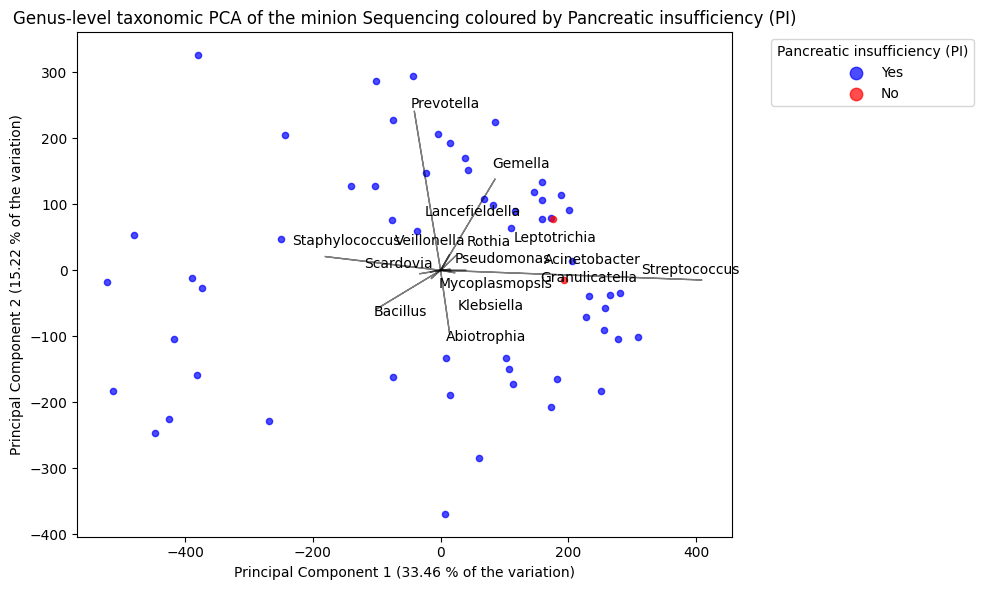

In [7]:
pw_condition = 'Pancreatic insufficiency (PI)'
fig, ax = plt.subplots(figsize=(10, 6))

color_map = {'Yes': 'blue', 'No': 'red'}

for yn in metadata[pw_condition].dropna().unique():
    if yn == '2':
        continue
    filtered_pca = pca_df[pca_df.index.isin(metadata[metadata[pw_condition] == yn][sequence_type])]
    ax.scatter(filtered_pca['PC1'], filtered_pca['PC2'], 
                color=color_map[yn], label=yn, s=20, alpha=0.7)
    
# add the loadings ... we only plot maxloadings here
maxloadings = 15
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
for i in range(maxloadings):
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, 
              color='black', alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color='black'))

# specifically add Pseudomonas
pidx = top_loadings_df.index.get_loc('Pseudomonas')
xpos = top_loadings_df.iloc[pidx, 0]*plotscaler
ypos = top_loadings_df.iloc[pidx, 1]*plotscaler
plt.arrow(0, 0, xpos, ypos, color='black', alpha=0.5, width=0.05)
texts.append(plt.text(xpos, ypos, top_loadings_df.index[pidx], color='black'))
    
adjust_text(texts)

# Add labels and legend
plt.title(f'{tax.capitalize()}-level taxonomic PCA of the {sequence_type} Sequencing coloured by {pw_condition}')
plt.xlabel(f'Principal Component 1 ({pc1_variance:.2f} % of the variation)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.2f} % of the variation)')
# plt.legend([])
# Display legend with the person labels
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=2, title=pw_condition)

# Show plot
plt.tight_layout()
plt.savefig(f"img/pancreatic_insufficieny_pca_{sequence_type}.png")
plt.show()


## Plot antibiotic usage

In [8]:
pathogens = {
    "Streptococcus",
    "Staphylococcus",
    "Haemophilus",
    "Mycobacterium",
    "Pseudomonas",
    "Klebsiella",
    "Moraxella",
    "Bordetella",
    "Legionella",
    "Corynebacterium",
    "Chlamydia",
    "Mycoplasma",
    "Neisseria",
    "Burkholderia",
    "Acinetobacter",
    "Francisella",
    "Escherichia",
    "Pasteurella",
    "Nocardia",
    "Actinomyces"
}


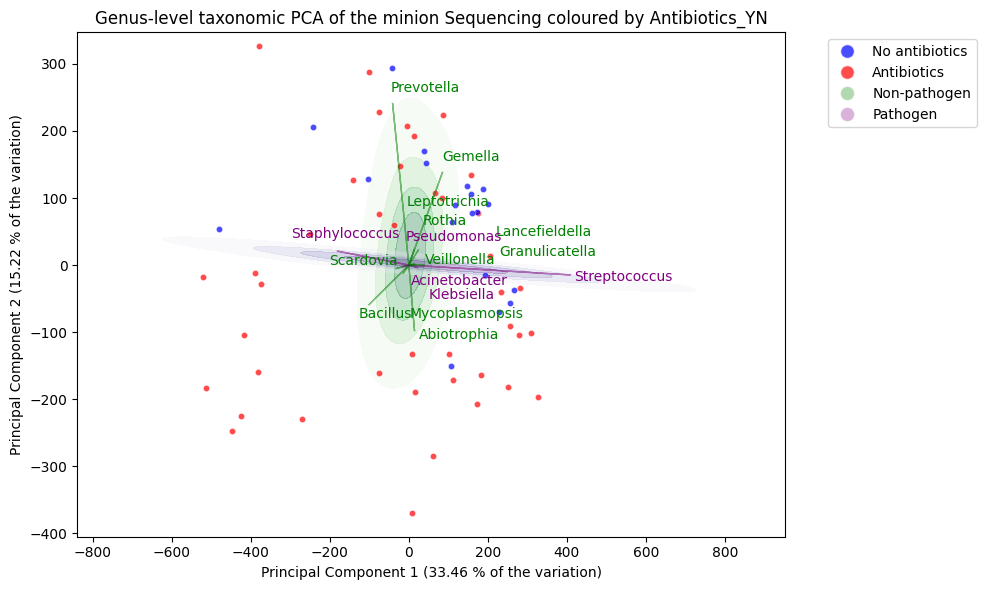

In [9]:
pw_condition = 'Antibiotics_YN'

fig, ax = plt.subplots(figsize=(10, 6))

color_map = {'Yes': 'red', 'No': 'blue'}

pathogen_loading = scaled_loadings_df[scaled_loadings_df.index.isin(pathogens)]
non_pathogen_loading = scaled_loadings_df[~scaled_loadings_df.index.isin(pathogens)]
tls = top_loadings_df.iloc[:10,:]
pathogen_loading = tls[tls.index.isin(pathogens)]
non_pathogen_loading = tls[~tls.index.isin(pathogens)]
# add the loadings as a kde based on if they are pathogens or not!
scaled_loadings_df['pathogen'] = np.where(scaled_loadings_df.index.isin(pathogens), 'Pathogen', 'Non-pathogen')

sns.kdeplot(data=non_pathogen_loading, x='PC1', y='PC2', fill=True, alpha=0.3, cmap='Greens', levels=5, ax=ax, bw_adjust=2)
sns.kdeplot(data=pathogen_loading, x='PC1', y='PC2', fill=True, alpha=0.3, cmap='Purples', levels=5, ax=ax, bw_adjust=2)
# sns.kdeplot(data=non_pathogen_loading, x='PC1', y='PC2', fill=True, alpha=0.5, cmap='Greens', levels=50, thresh=0, ax=ax, bw_adjust=100)

# sns.kdeplot(data=scaled_loadings_df, x='PC1', y='PC2', hue='pathogen', fill=True, alpha=0.5, thresh=0, levels=500, ax=ax, bw_adjust=100, cut=0, clip=(-500,500))
#sns.kdeplot(data=scaled_loadings_df, x='PC1', y='PC2', hue='pathogen', fill=True, alpha=0.5, levels=500, ax=ax, bw_adjust=100, cut=0)

for yn in metadata[pw_condition].dropna().unique():
    if yn == '2':
        continue
    filtered_pca = pca_df[pca_df.index.isin(metadata[metadata[pw_condition] == yn][sequence_type])]
    sns.scatterplot(x=filtered_pca['PC1'], y=filtered_pca['PC2'], ax=ax,
                color=color_map[yn], label=yn, s=20, alpha=0.7)


maxloadings = 15
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
for i in range(maxloadings):
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    linecolour = 'purple' if top_loadings_df.index[i] in pathogens else 'green'
    plt.arrow(0, 0, xpos, ypos, 
              color=linecolour, alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color=linecolour))

# specifically add Pseudomonas
pidx = top_loadings_df.index.get_loc('Pseudomonas')
xpos = top_loadings_df.iloc[pidx, 0]*plotscaler
ypos = top_loadings_df.iloc[pidx, 1]*plotscaler
linecolour = 'purple' if top_loadings_df.index[pidx] else 'green'
plt.arrow(0, 0, xpos, ypos, color=linecolour, alpha=0.5, width=0.05)
texts.append(plt.text(xpos, ypos, top_loadings_df.index[pidx], color=linecolour))
    
adjust_text(texts)

# add a custom legend
patches = []
patches.append(plt.Line2D([0], [0], marker='o', color='w', label='No antibiotics', 
                         markerfacecolor='blue', alpha=0.7, markersize=10))
patches.append(plt.Line2D([0], [0], marker='o', color='w', label='Antibiotics', 
                        markerfacecolor='red', alpha=0.7, markersize=10))
patches.append(plt.Line2D([0], [0], marker='o', color='w', label='Non-pathogen', 
                         markerfacecolor='green', alpha=0.3, markersize=10))
patches.append(plt.Line2D([0], [0], marker='o', color='w', label='Pathogen', 
                        markerfacecolor='purple', alpha=0.3, markersize=10))


plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    
# Add labels and legend
plt.title(f'{tax.capitalize()}-level taxonomic PCA of the {sequence_type} Sequencing coloured by {pw_condition}')
plt.xlabel(f'Principal Component 1 ({pc1_variance:.2f} % of the variation)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.2f} % of the variation)')
# plt.legend([])
# Display legend with the person labels
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=2, title=pw_condition)

plt.tight_layout()
plt.savefig(f"img/antibiotics_pca_{sequence_type}.png")
plt.show()


# Hospital and in-patient vs out-patient

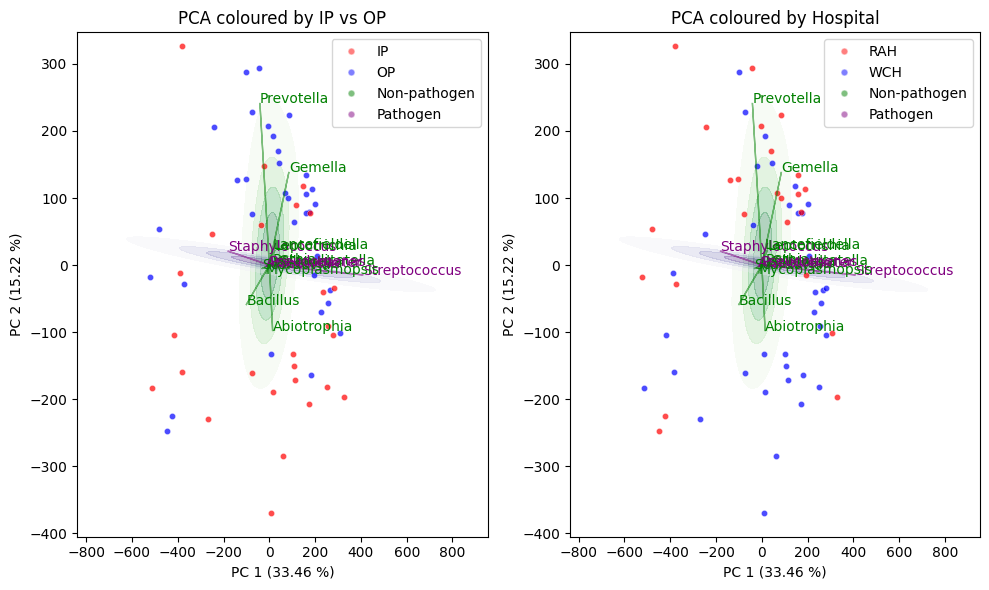

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

color_map = {'Yes': 'red', 'No': 'blue', 'IP': 'red', 'OP': 'blue', 'RAH': 'red', 'WCH': 'blue'}

pathogen_loading = scaled_loadings_df[scaled_loadings_df.index.isin(pathogens)]
non_pathogen_loading = scaled_loadings_df[~scaled_loadings_df.index.isin(pathogens)]
tls = top_loadings_df.iloc[:10,:]
pathogen_loading = tls[tls.index.isin(pathogens)]
non_pathogen_loading = tls[~tls.index.isin(pathogens)]
# add the loadings as a kde based on if they are pathogens or not!
scaled_loadings_df['pathogen'] = np.where(scaled_loadings_df.index.isin(pathogens), 'Pathogen', 'Non-pathogen')

for ax in axes:
    sns.kdeplot(data=non_pathogen_loading, x='PC1', y='PC2', fill=True, alpha=0.3, cmap='Greens', levels=5, ax=ax, bw_adjust=2)
    sns.kdeplot(data=pathogen_loading, x='PC1', y='PC2', fill=True, alpha=0.3, cmap='Purples', levels=5, ax=ax, bw_adjust=2)

    
maxloadings = 15
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2

texts = []
for axi, pw_condition in enumerate(['IP vs OP', 'Hospital']):
    ax = axes[axi]
    for yn in metadata[pw_condition].dropna().unique():
        if yn == '2':
            continue
        filtered_pca = pca_df[pca_df.index.isin(metadata[metadata[pw_condition] == yn]['minion'])]
        sns.scatterplot(x=filtered_pca['PC1'], y=filtered_pca['PC2'], ax=ax,
                    color=color_map[yn], label=yn, s=20, alpha=0.7)
        #axes[axi].legend(title=pw_condition)

    
    for i in range(maxloadings):
        xpos = top_loadings_df.iloc[i, 0]*plotscaler
        ypos = top_loadings_df.iloc[i, 1]*plotscaler
        linecolour = 'purple' if top_loadings_df.index[i] in pathogens else 'green'
        ax.arrow(0, 0, xpos, ypos, 
                  color=linecolour, alpha=0.5, width=0.05)
        texts.append(ax.text(xpos, ypos, top_loadings_df.index[i], color=linecolour))

    # specifically add Pseudomonas
    pidx = top_loadings_df.index.get_loc('Pseudomonas')
    xpos = top_loadings_df.iloc[pidx, 0]*plotscaler
    ypos = top_loadings_df.iloc[pidx, 1]*plotscaler
    linecolour = 'purple' if top_loadings_df.index[pidx] else 'green'
    ax.arrow(0, 0, xpos, ypos, color=linecolour, alpha=0.5, width=0.05)
    texts.append(ax.text(xpos, ypos, top_loadings_df.index[pidx], color=linecolour))
    
    ax.set_xlabel(f'PC 1 ({pc1_variance:.2f} %)')
    ax.set_ylabel(f'PC 2 ({pc2_variance:.2f} %)')


    # add a custom legend
    patches = []
    if pw_condition == 'IP vs OP':
        patches.append(plt.Line2D([0], [0], marker='o', color='w', label='IP', 
                                 markerfacecolor='red', alpha=0.5, markersize=5))
        patches.append(plt.Line2D([0], [0], marker='o', color='w', label='OP', 
                                markerfacecolor='blue', alpha=0.5, markersize=5))
    else:
        patches.append(plt.Line2D([0], [0], marker='o', color='w', label='RAH', 
                                 markerfacecolor='red', alpha=0.5, markersize=5))
        patches.append(plt.Line2D([0], [0], marker='o', color='w', label='WCH', 
                                markerfacecolor='blue', alpha=0.5, markersize=5))
    patches.append(plt.Line2D([0], [0], marker='o', color='w', label='Non-pathogen', 
                             markerfacecolor='green', alpha=0.5, markersize=5))
    patches.append(plt.Line2D([0], [0], marker='o', color='w', label='Pathogen', 
                            markerfacecolor='purple', alpha=0.5, markersize=5))


    ax.legend(handles=patches)
    ax.set_title(f'PCA coloured by {pw_condition}')

# Show plot
plt.tight_layout()
plt.savefig(f"img/ip_op_hosp_pca_{sequence_type}.png")
plt.show()


## Age and Gender

In [11]:
metadata['Gender'].unique()

array(['F', 'M'], dtype=object)

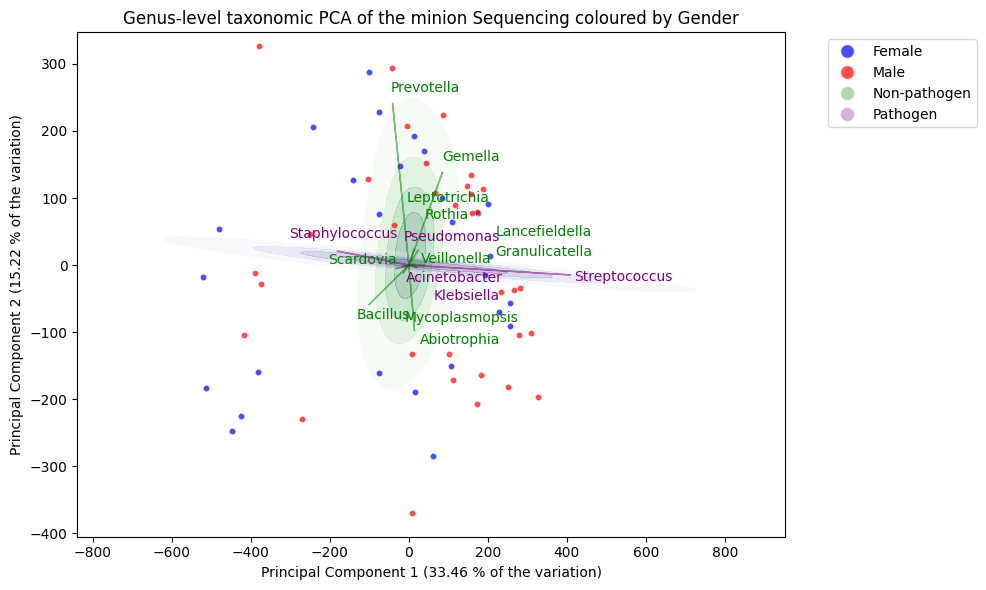

In [12]:
pw_condition = 'Gender'

fig, ax = plt.subplots(figsize=(10, 6))

color_map = {'M': 'red', 'F': 'blue'}

pathogen_loading = scaled_loadings_df[scaled_loadings_df.index.isin(pathogens)]
non_pathogen_loading = scaled_loadings_df[~scaled_loadings_df.index.isin(pathogens)]
tls = top_loadings_df.iloc[:10,:]
pathogen_loading = tls[tls.index.isin(pathogens)]
non_pathogen_loading = tls[~tls.index.isin(pathogens)]
# add the loadings as a kde based on if they are pathogens or not!
scaled_loadings_df['pathogen'] = np.where(scaled_loadings_df.index.isin(pathogens), 'Pathogen', 'Non-pathogen')

sns.kdeplot(data=non_pathogen_loading, x='PC1', y='PC2', fill=True, alpha=0.3, cmap='Greens', levels=5, ax=ax, bw_adjust=2)
sns.kdeplot(data=pathogen_loading, x='PC1', y='PC2', fill=True, alpha=0.3, cmap='Purples', levels=5, ax=ax, bw_adjust=2)
# sns.kdeplot(data=non_pathogen_loading, x='PC1', y='PC2', fill=True, alpha=0.5, cmap='Greens', levels=50, thresh=0, ax=ax, bw_adjust=100)

# sns.kdeplot(data=scaled_loadings_df, x='PC1', y='PC2', hue='pathogen', fill=True, alpha=0.5, thresh=0, levels=500, ax=ax, bw_adjust=100, cut=0, clip=(-500,500))
#sns.kdeplot(data=scaled_loadings_df, x='PC1', y='PC2', hue='pathogen', fill=True, alpha=0.5, levels=500, ax=ax, bw_adjust=100, cut=0)

for yn in metadata[pw_condition].dropna().unique():
    if yn == '2':
        continue
    filtered_pca = pca_df[pca_df.index.isin(metadata[metadata[pw_condition] == yn]['minion'])]
    sns.scatterplot(x=filtered_pca['PC1'], y=filtered_pca['PC2'], ax=ax,
                color=color_map[yn], label=yn, s=20, alpha=0.7)


maxloadings = 15
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
for i in range(maxloadings):
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    linecolour = 'purple' if top_loadings_df.index[i] in pathogens else 'green'
    plt.arrow(0, 0, xpos, ypos, 
              color=linecolour, alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color=linecolour))

# specifically add Pseudomonas
pidx = top_loadings_df.index.get_loc('Pseudomonas')
xpos = top_loadings_df.iloc[pidx, 0]*plotscaler
ypos = top_loadings_df.iloc[pidx, 1]*plotscaler
linecolour = 'purple' if top_loadings_df.index[pidx] else 'green'
plt.arrow(0, 0, xpos, ypos, color=linecolour, alpha=0.5, width=0.05)
texts.append(plt.text(xpos, ypos, top_loadings_df.index[pidx], color=linecolour))
    
adjust_text(texts)

# add a custom legend
patches = []
patches.append(plt.Line2D([0], [0], marker='o', color='w', label='Female', 
                         markerfacecolor='blue', alpha=0.7, markersize=10))
patches.append(plt.Line2D([0], [0], marker='o', color='w', label='Male', 
                        markerfacecolor='red', alpha=0.7, markersize=10))
patches.append(plt.Line2D([0], [0], marker='o', color='w', label='Non-pathogen', 
                         markerfacecolor='green', alpha=0.3, markersize=10))
patches.append(plt.Line2D([0], [0], marker='o', color='w', label='Pathogen', 
                        markerfacecolor='purple', alpha=0.3, markersize=10))


plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    
# Add labels and legend
plt.title(f'{tax.capitalize()}-level taxonomic PCA of the {sequence_type} Sequencing coloured by {pw_condition}')
plt.xlabel(f'Principal Component 1 ({pc1_variance:.2f} % of the variation)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.2f} % of the variation)')
# plt.legend([])
# Display legend with the person labels
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=2, title=pw_condition)

plt.tight_layout()
plt.show()


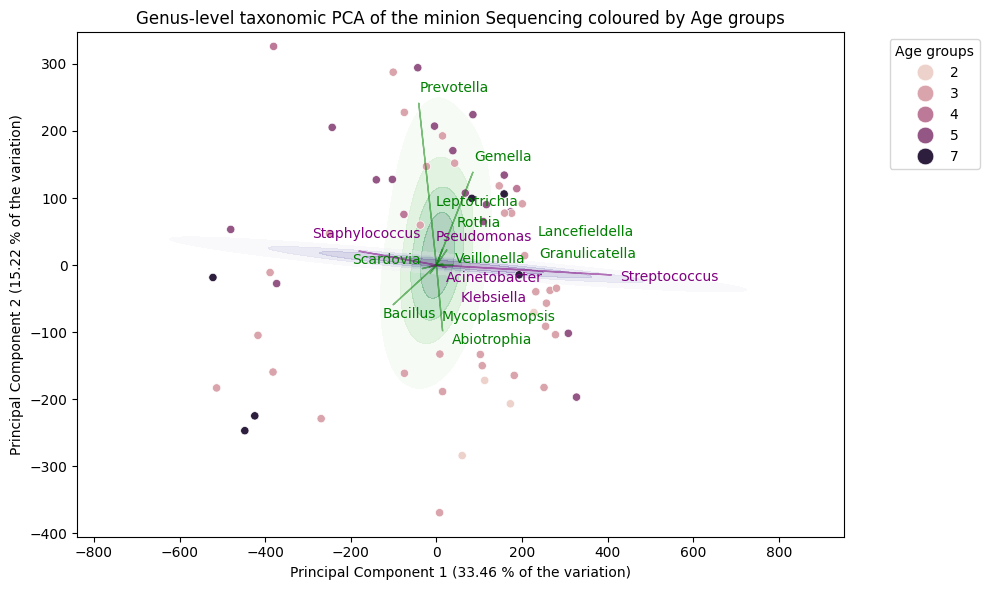

In [13]:
pw_condition = 'Age groups'

fig, ax = plt.subplots(figsize=(10, 6))


pathogen_loading = scaled_loadings_df[scaled_loadings_df.index.isin(pathogens)]
non_pathogen_loading = scaled_loadings_df[~scaled_loadings_df.index.isin(pathogens)]
tls = top_loadings_df.iloc[:10,:]
pathogen_loading = tls[tls.index.isin(pathogens)]
non_pathogen_loading = tls[~tls.index.isin(pathogens)]
# add the loadings as a kde based on if they are pathogens or not!
scaled_loadings_df['pathogen'] = np.where(scaled_loadings_df.index.isin(pathogens), 'Pathogen', 'Non-pathogen')

sns.kdeplot(data=non_pathogen_loading, x='PC1', y='PC2', fill=True, alpha=0.3, cmap='Greens', levels=5, ax=ax, bw_adjust=2)
sns.kdeplot(data=pathogen_loading, x='PC1', y='PC2', fill=True, alpha=0.3, cmap='Purples', levels=5, ax=ax, bw_adjust=2)

filtered_pca = pca_df.join(metadata['Age groups'])
g = sns.scatterplot(filtered_pca, x='PC1', y='PC2', ax=ax, hue='Age groups')



maxloadings = 15
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
for i in range(maxloadings):
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    linecolour = 'purple' if top_loadings_df.index[i] in pathogens else 'green'
    plt.arrow(0, 0, xpos, ypos, 
              color=linecolour, alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color=linecolour))

# specifically add Pseudomonas
pidx = top_loadings_df.index.get_loc('Pseudomonas')
xpos = top_loadings_df.iloc[pidx, 0]*plotscaler
ypos = top_loadings_df.iloc[pidx, 1]*plotscaler
linecolour = 'purple' if top_loadings_df.index[pidx] else 'green'
plt.arrow(0, 0, xpos, ypos, color=linecolour, alpha=0.5, width=0.05)
texts.append(plt.text(xpos, ypos, top_loadings_df.index[pidx], color=linecolour))
    
adjust_text(texts)



    
# Add labels and legend
plt.title(f'{tax.capitalize()}-level taxonomic PCA of the {sequence_type} Sequencing coloured by {pw_condition}')
plt.xlabel(f'Principal Component 1 ({pc1_variance:.2f} % of the variation)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.2f} % of the variation)')
# plt.legend([])
# Display legend with the person labels
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=2, title=pw_condition)

plt.tight_layout()
plt.show()
